# 第5回講義 演習

## 課題. Theanoの基礎を学ぶ

In [2]:
%matplotlib inline
from __future__ import division
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score
from sklearn.datasets import fetch_mldata
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from collections import OrderedDict

import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

trng = RandomStreams(42)
rng =  np.random.RandomState(1234)

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


### 1. MNISTデータセットの読み込み

In [21]:
mnist = fetch_mldata('MNIST original')
mnist_X, mnist_y = shuffle(mnist.data.astype('float32'), mnist.target.astype('int32'))

mnist_X = mnist_X / 255.0

train_X, test_X, train_y, test_y = train_test_split(mnist_X, mnist_y, test_size=0.2)

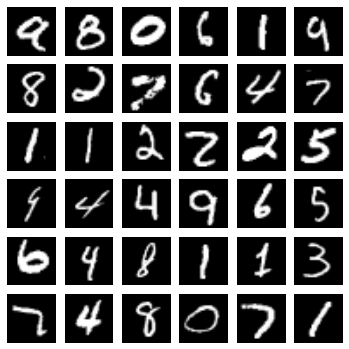

In [4]:
#--- Show Randomly picked Examples
def plot_sample(x, axis):
    img = x.reshape(28, 28)
    axis.imshow(img, cmap='gray')
    
fig = plt.figure(figsize=(6, 6))
for i in range(36):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    plot_sample(mnist_X[np.random.randint(0,60000)], ax)

### 2. Theanoの概観

In [5]:
#--- Linear Regression
#- Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #input

W = theano.shared(rng.uniform(low=-0.08, high=0.08, size=(5, 3)).astype('float32'), name="W") #variables that are shared over iteration: weight, bias
b = theano.shared(np.zeros(3), name="b")

#- Step2. Define graph
y = T.dot(x, W) + b

cost = T.sum((y - t)**2) #Cost function

gW, gb = T.grad(cost=cost, wrt=[W, b]) # Take gradient

updates = OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


#- Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], 
                    updates=updates, allow_input_downcast=True)

#- Step4. Run!!
for epoch in xrange(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


### 3. 変数

- シンボル変数(Symbolic Variable): 関数間で値が共有されない変数 (入力のxなどに使用)
- 共有変数(Shared Variable): 関数間で値が共有される変数 (重みのWなど更新されるものに使用)

#### シンボル変数の例

In [6]:
def identity(a):
    return a

a = T.iscalar('a')
f = theano.function(inputs=[a], outputs=a)

print identity(1)
print f(1)

1
1


#### 共有変数の例

In [7]:
W = theano.shared(np.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")

print W
print W.get_value()

W.set_value(np.array([1, 2, 3, 4, 5]).astype("float32"))
print W.get_value()

W
[ 0.  1.  2.  3.  4.]
[ 1.  2.  3.  4.  5.]


#### まとめ

In [8]:
## Symbolic Variables 
a = T.iscalar("a")  # integer
b = T.fscalar("b")  # float scalar

x = T.fvector("x")  # float vector
X = T.fmatrix("X")  # float matrix

## Shared Variable, store variables on cpu/gpu memory
W = theano.shared(np.array([0., 1., 2., 3., 4.]).astype("float32"), name="W")
bias = theano.shared(np.float32(5), name="bias")

# Get Value from shared variable
print W.get_value() 

## Define symbolic graph
c = a + b
y = T.dot(x, W) + bias

## Print symbolic graph
print theano.pp(y)

##  Advanced:: You can replace some parts of computation graph with different variable
d = theano.clone(output=c, replace={b: y}) #replace "b" with "y"
print theano.pp(d)

[ 0.  1.  2.  3.  4.]
((x \dot W) + bias)
(a + ((x \dot W) + bias))


### 4. 関数

**注意**:: int32とfloat32だけ使える. また, GPUで高速化されるのはfloat32だけ

In [9]:
#- Compile symbplic graph into callable functions
add = theano.function(inputs=[a, b], outputs=c)
linear = theano.function(inputs=[x], outputs=y)

#- Call Functions
print add(1, 5)
print linear([0., 0., 0., 0., 1.]).astype("float32")

#- Print function
theano.printing.debugprint(linear)

#- Advanced :: You can evaluate symbolic graph without compilation
print c.eval({
                        a : np.int32(16), 
                        b : np.float32(12.10)
                     })

6.0
9.0
Elemwise{Add}[(0, 0)] [id A] ''   4
 |InplaceDimShuffle{} [id B] ''   3
 | |CGemv{inplace} [id C] ''   2
 |   |AllocEmpty{dtype='float32'} [id D] ''   1
 |   | |TensorConstant{1} [id E]
 |   |TensorConstant{1.0} [id F]
 |   |InplaceDimShuffle{x,0} [id G] ''   0
 |   | |W [id H]
 |   |x [id I]
 |   |TensorConstant{0.0} [id J]
 |bias [id K]
28.1000003815


### 5. 数学

Theanoの多くの数学演算子はnumpyと似てる. ただ, 比較演算子は特殊 [[リンク](http://deeplearning.net/software/theano/library/tensor/basic.html)]

条件演算子は
```python
T.switch(condition, if true, if false)
```

比較は
```python
T.gt(a, b) # greater than
```

#### 例

In [10]:
x = T.fvector("x")

### Basic Math operation & Activation functions
exp_x = T.exp(x)
sigmoid_x = T.nnet.sigmoid(x)
tanh_x = T.tanh(x)

### Advanced:: condition and comparison
#max(0,x)
relu_x = T.switch(T.gt(x, 0), x, 0)

f = theano.function(inputs=[x], outputs=[exp_x, sigmoid_x, tanh_x, relu_x])
f(np.array([-2., -1., 1., 2., 3.]).astype("float32"))

[array([  0.13533528,   0.36787945,   2.71828175,   7.38905621,  20.08553696], dtype=float32),
 array([ 0.11920292,  0.26894143,  0.7310586 ,  0.88079709,  0.95257413], dtype=float32),
 array([-0.96402758, -0.76159418,  0.76159418,  0.96402758,  0.99505478], dtype=float32),
 array([ 0.,  0.,  1.,  2.,  3.], dtype=float32)]

### 6. 勾配 (自動微分)

勾配を自動的に定義できる!!!

ヤコビアンorヘシアンを使いたいときはtheano.gradient.jacobian, theano.gradient.hessianを

#### 自動微分の例

In [11]:
# y = x ** 2
x = T.fscalar("x")
y = x ** 2
gy = theano.grad(cost=y, wrt=x) ## 2x

f = theano.function(inputs=[x], outputs=[y, gy]) ## x**2, 2x
print f(10)

[array(100.0, dtype=float32), array(20.0, dtype=float32)]


#### パラメータ(共有変数)の更新

In [12]:
a = 0
for i in xrange(5):
    print a
    a += 1

0
1
2
3
4


In [13]:
a = theano.shared(np.int32(0))
increment = theano.function(inputs=[], outputs=a, updates={a:a+1})
for i in xrange(5):
    print increment()

0
1
2
3
4


In [14]:
##Define a function which update t by 1 for each call.
t = theano.shared(np.int32(0))
increment = theano.function(inputs=[], outputs=t, updates=OrderedDict({t: t+1}) ) #OrderedDict({before update: after update})
for i in xrange(5):
    t = increment()
    print t

0
1
2
3
4


#### 自動微分を使ってロジスティック回帰

In [15]:
# Linear Regression
rng = np.random.RandomState(1234)

##  Step1. Define Symbolic / Shared Variables
x, t = T.fvector("x"), T.fvector("t") #inputs


W = theano.shared(rng.uniform(low=-0.08,high=0.08, size=(5, 3)).astype('float32'), name="W") #variables that are shared over iterations
b =  theano.shared(np.zeros(3).astype('float32'), name="b")


## Step2. Define graph
y = T.dot(x, W) + b
#y = T.nnet.sigmoid(T.dot(x, W) + b)
#y = T.tanh(T.dot(x, W) + b)
cost = T.sum((y - t)**2)


gW, gb = T.grad(cost=cost, wrt=[W, b]) # Take gradient

updates =  OrderedDict({W: W-0.01*gW, b: b-0.01*gb}) # Set update expression in OrderedDict


## Step3. Compile graph
f = theano.function(inputs=[x, t], outputs=[cost, gW, gb], updates=updates, allow_input_downcast=True)

## Step4. Run!!
for epoch in xrange(5):
    cost, gW, gb = f([-2., -1., 1., 2., 3.], [.4, .3, .5])
    print "epoch:: %d, cost:: %.3f"%(epoch, cost)

epoch:: 0, cost:: 0.295
epoch:: 1, cost:: 0.106
epoch:: 2, cost:: 0.038
epoch:: 3, cost:: 0.014
epoch:: 4, cost:: 0.005


### 7. 多層パーセプトロン (Multi Layer Perceptron, MLP)

<img src="http://k-kawakami.com/img/mlp.png">

In [ ]:
train_y = np.eye(10)[train_y]
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

#--- Multi Layer Perceptron
class Layer:
    #- Constructor
    def __init__(self, in_dim, out_dim, function):
        self.in_dim   = in_dim
        self.out_dim  = out_dim                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
        self.function = function
        self.W        = theano.shared(0.001 * np.random.randn(in_dim, out_dim).astype("float32"))
        self.b        = theano.shared(np.zeros(out_dim).astype("float32"))
        self.params   = [self.W, self.b]

    #- Forward Propagation
    def f_prop(self, x):
        self.z = self.function(T.dot(x, self.W) + self.b)
        return self.z

#--- Stochastic Gradient Descent
def sgd(params, g_params, eps=np.float32(0.1)):
    updates = OrderedDict()
    for param, g_param in zip(params, g_params):
        updates[param] = param - eps * g_param
    return updates

layers = [
    Layer(train_X.shape[1], 800, T.nnet.sigmoid),
    Layer(800, 10, T.nnet.softmax)
]

x = T.fmatrix('x')
t = T.imatrix('t')

params = []
for i, layer in enumerate(layers):
    params += layer.params
    if i == 0:
        layer_out = layer.f_prop(x)
    else:
        layer_out = layer.f_prop(layer_out)

y = layers[-1].z
cost = T.mean(T.nnet.categorical_crossentropy(y, t))

g_params = T.grad(cost=cost, wrt=params)
updates = sgd(params, g_params)

train = theano.function(inputs=[x, t], outputs=cost, updates=updates, allow_input_downcast=True, name='train')
valid = theano.function(inputs=[x, t], outputs=[cost, T.argmax(y, axis=1)], allow_input_downcast=True, name='valid')
test  = theano.function(inputs=[x], outputs=T.argmax(y, axis=1), name='test')

batch_size = 100
n_batches = train_X.shape[0]//batch_size
for epoch in xrange(50):
    train_X, train_y = shuffle(train_X, train_y)
    for i in xrange(n_batches):
        start = i*batch_size
        end = start + batch_size
        train(train_X[start:end], train_y[start:end])
    valid_cost, pred_y = valid(valid_X, valid_y)
    print 'EPOCH:: %i, Validation cost: %.3f, Validation F1: %.3f' % (epoch + 1, valid_cost, f1_score(np.argmax(valid_y, axis=1).astype('int32'), pred_y, average='macro'))

In [24]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")


from theano import function, config, shared, sandbox
import theano.tensor as T
import numpy
import time

vlen = 10 * 30 * 768  # 10 x #cores x # threads per core
iters = 1000

rng = numpy.random.RandomState(22)
x = shared(numpy.asarray(rng.rand(vlen), config.floatX))
f = function([], T.exp(x))
print(f.maker.fgraph.toposort())
t0 = time.time()
for i in range(iters):
    r = f()
t1 = time.time()
print("Looping %d times took %f seconds" % (iters, t1 - t0))
print("Result is %s" % (r,))
if numpy.any([isinstance(x.op, T.Elemwise) for x in f.maker.fgraph.toposort()]):
    print('Used the cpu')
else:
    print('Used the gpu')

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu0 is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)


[Elemwise{exp,no_inplace}(<TensorType(float32, vector)>)]
Looping 1000 times took 2.779833 seconds
Result is [ 1.23178029  1.61879337  1.52278066 ...,  2.20771813  2.29967761
  1.62323284]
Used the cpu


### 8. 参考資料

1. [Theano Documentation](http://deeplearning.net/software/theano/introduction.html)
2. [Deep Learning Tutorial](http://deeplearning.net/tutorial/)
3. F. Bastien, P. Lamblin, R. Pascanu, J. Bergstra, I. Goodfellow, A. Bergeron, N. Bouchard, D. Warde-Farley and Y. Bengio. [Theano: new features nd speed improvements"](http://arxiv.org/pdf/1211.5590.pdf). NIPS 2012 deep learning workshop.
4. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. [Theano: A CPU and GPU Math Expression Compiler](http://www.iro.umontreal.ca/~lisa/pointeurs/theano_scipy2010.pdf). Proceedings of the Python for Scientific Computing Conference (SciPy) 2010. June 30 - July 3, Austin, TX
5. [Wikipedia, Convolution](https://en.wikipedia.org/wiki/Convolution)
6. [Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/UFLDL_Tutorial)